# Классификация дефектов кожи

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [4]:
print(tf.__version__)

2.4.0


In [5]:
from tensorflow.keras.applications import InceptionV3

In [6]:
keras.applications.EfficientNetB4()

78872576/78864416 [==============================] - 0s 0us/step


In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.0


# Задаем константы

In [8]:
train_path = "/kaggle/input/dermnet/train/"
test_path = "/kaggle/input/dermnet/test/"

In [9]:
RANDOM_SEED = 42
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 6
VAL_BATCH_SIZE = 8
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

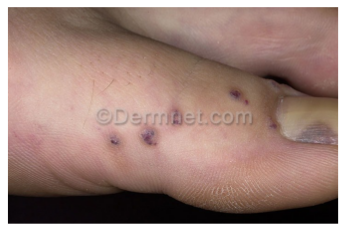

In [10]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "Vascular Tumors/angiokeratomas-18.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


In [11]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)
x

(472, 720, 3)


array([[[123.,  99.,  87.],
        [113.,  89.,  77.],
        [115.,  91.,  79.],
        ...,
        [102.,  75.,  58.],
        [100.,  73.,  56.],
        [ 98.,  71.,  54.]],

       [[122.,  98.,  86.],
        [122.,  98.,  86.],
        [114.,  90.,  78.],
        ...,
        [103.,  76.,  59.],
        [103.,  76.,  59.],
        [102.,  75.,  58.]],

       [[119.,  95.,  83.],
        [130., 106.,  94.],
        [117.,  93.,  81.],
        ...,
        [106.,  77.,  61.],
        [107.,  78.,  62.],
        [108.,  79.,  63.]],

       ...,

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        ...,
        [  3.,   1.,   2.],
        [  3.,   1.,   2.],
        [  3.,   1.,   2.]],

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 13.,   8.,  12.],
        ...,
        [  3.,   1.,   2.],
        [  3.,   1.,   2.],
        [  3.,   1.,   2.]],

       [[ 12.,   7.,  11.],
        [ 12.,   7.,  11.],
        [ 13.,  

In [12]:
# C помощью glob определяем сколько разных папок с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  23


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [13]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.


In [15]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 4002 images belonging to 23 classes.


In [ ]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [16]:
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-s7uo4oqz
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-s7uo4oqz
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=28c214c5c7da2e5a79efbee8157a1f76b3e7ec9913974e43f25f6cfdf9513021
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4d1p9p_/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [19]:
# попробовать

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=40),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
test_aug = Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p = 1.0),
            A.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=1.0),
            A.RandomCrop(height= HEIGHT, width = WIDTH,always_apply=True, p=1.0),
            Aug_Norm,
            ToTensorV2(p=1.0)
        ], p=1.)

In [ ]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=299, width=299),
        albumentations.CenterCrop(height=299, width=299),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [20]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.


In [21]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 4002 images belonging to 23 classes.


Пример картинок из train_generator


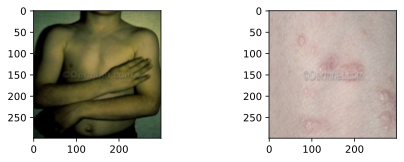

In [22]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [23]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(6, 299, 299, 3) (6, 23)


# Посмотрим распределение данных по классам.

In [21]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(train_path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

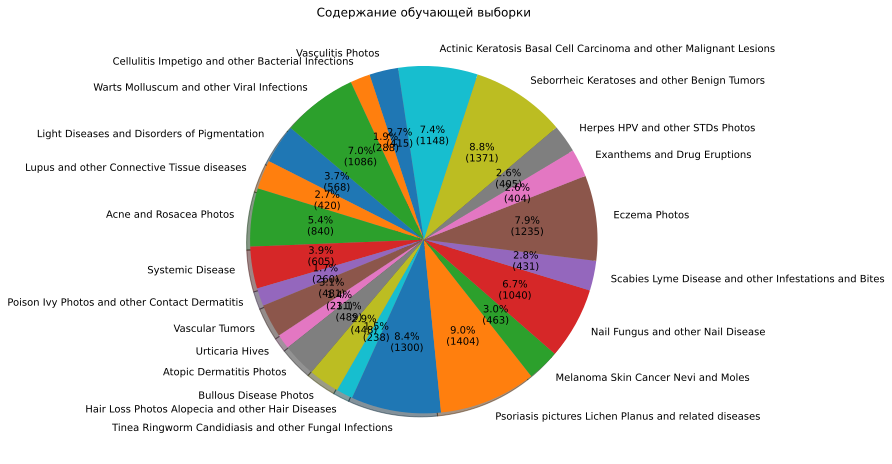

In [22]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

In [ ]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [52]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())

    index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar( values, values, width=10)
 #   plt.bar(range(len(values)),[values[k] for k in values], width=20)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

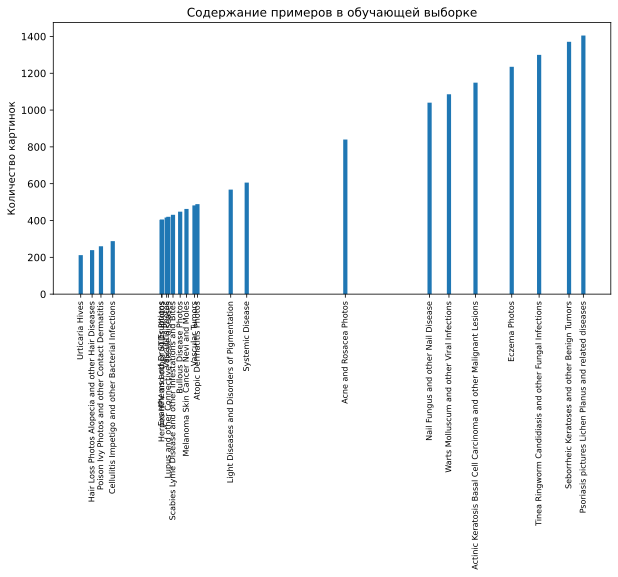

In [53]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

In [ ]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(train_generator))

# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [24]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [39]:
# CallBack для сохранения модели, ее весов и лучшей модели
weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True, save_best_only=True,
#checkpoint = ModelCheckpoint(weightpath , monitor = ['val_accuracy'] , save_best_only=True)
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.0000001,  verbose = 1, cooldown=2, mode='auto',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001
#early_stop= EarlyStopping(monitor='val_accuracy',patience= 10, restore_best_weights=True)

In [40]:
# EarlyStopping для остановки обучения, когда отслеживаемый показатель перестал улучшаться.

#early_stop= EarlyStopping(min_delta=0.001, verbose=1, mode="max", restore_best_weights=False) #  patience=7,

#callbacks_list = [checkpoint] #, early_stop]
callbacks_list = [checkpoint, reducer, early_stop] #reducer

## Шаг1  Сформирмируем сверточную нейросеть CNN

In [27]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

71688192/71686520 [==============================] - 1s 0us/step


In [28]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [60]:
model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [29]:
# лучшая модель 22%

model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.15))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [30]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 13
Number of trainable_variables layers in the model: 12
Number of layers in the base model:  474
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f3aace54850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3aea3d50d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3a0e9bcd90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3aea8c2a10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3a0e9c1390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3a0e9cbf50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3a0e951d50> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3a0e95bb10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3a0e9c2890> True
<tensorflow.python.kera

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        1032256   
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         147712    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1

In [69]:
# Посмотрим структуру модели

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        1032256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 256)         147712    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 256)        

In [ ]:
# Посмотрим на схему модели.

from tensorflow.keras import utils

utils.plot_model(model)

In [32]:
# Компилируем модель

LR=0.0001
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [33]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 15, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
2076/2076 [==============================] - 343s 158ms/step - loss: 3.1391 - accuracy: 0.0781 - val_loss: 2.9957 - val_accuracy: 0.0796

Epoch 00001: val_accuracy improved from -inf to 0.07957, saving model to best_model.hdf5
Epoch 2/15
2076/2076 [==============================] - 223s 107ms/step - loss: 3.0179 - accuracy: 0.0865 - val_loss: 2.9824 - val_accuracy: 0.0883

Epoch 00002: val_accuracy improved from 0.07957 to 0.08827, saving model to best_model.hdf5
Epoch 3/15
2076/2076 [==============================] - 221s 106ms/step - loss: 3.0111 - accuracy: 0.0955 - val_loss: 2.9843 - val_accuracy: 0.0883

Epoch 00003: val_accuracy did not improve from 0.08827
Epoch 4/15
2076/2076 [==============================] - 219s 106ms/step - loss: 3.0056 - accuracy: 0.0861 - val_loss: 2.9815 - val_accuracy: 0.0905

Epoch 00004: val_accuracy improved from 0.08827 to 0.09053, saving model to best_model.hdf5
Epoch 5/15
2076/2076 [==============================] - 217s 105ms/step - lo

In [34]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_s1.hdf5')
model.load_weights('best_model.hdf5')

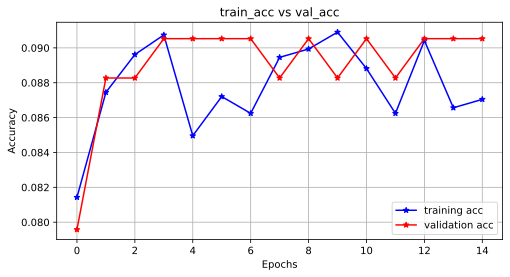

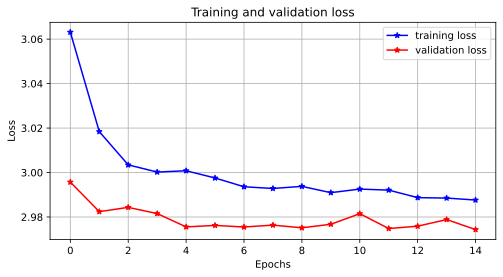

In [35]:
graph(history)

In [ ]:
шаг2

In [36]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 383

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [37]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 13
Number of trainable_variables layers in the model: 93
Number of layers in the base model:  474
Number of variables layers in the base model:  81
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f3aace54850> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3aea3d50d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3a0e9bcd90> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3aea8c2a10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3a0e9c1390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3a0e9cbf50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f3a0e951d50> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f3a0e95bb10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3a0e9c2890> True
<tensorflow.python.kera

In [38]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 64)        1032256   
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         147712    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1

In [41]:
# Компилируем модель

LR=0.001
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


In [42]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 10, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/10
2076/2076 [==============================] - 257s 118ms/step - loss: 3.0377 - accuracy: 0.0806 - val_loss: 2.9810 - val_accuracy: 0.0905

Epoch 00001: val_accuracy improved from -inf to 0.09053, saving model to best_model.hdf5
Epoch 2/10
2076/2076 [==============================] - 239s 115ms/step - loss: 2.9923 - accuracy: 0.0848 - val_loss: 2.9776 - val_accuracy: 0.0883

Epoch 00002: val_accuracy did not improve from 0.09053
Epoch 3/10
2076/2076 [==============================] - 241s 116ms/step - loss: 2.9850 - accuracy: 0.0883 - val_loss: 2.9777 - val_accuracy: 0.0905

Epoch 00003: val_accuracy did not improve from 0.09053
Epoch 4/10
2076/2076 [==============================] - 239s 115ms/step - loss: 2.9886 - accuracy: 0.0863 - val_loss: 2.9755 - val_accuracy: 0.0883

Epoch 00004: val_accuracy did not improve from 0.09053
Epoch 5/10
2076/2076 [==============================] - 238s 115ms/step - loss: 2.9744 - accuracy: 0.0878 - val_loss: 2.9748 - val_accuracy: 0.0883

E

In [43]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_st2.hdf5')
model.load_weights('best_model.hdf5')

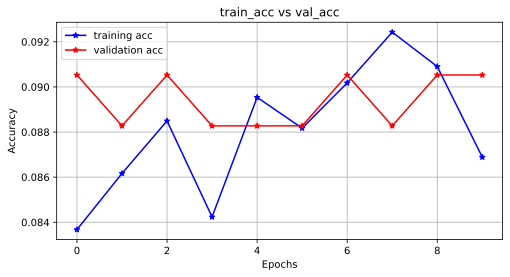

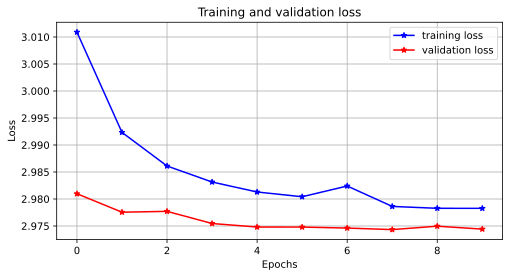

In [44]:
graph(history)

In [ ]:
# Шаг3

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 68

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

In [ ]:
# Посмотрим структуру модели

model.summary()

In [ ]:
# Компилируем модель

LR=0.0003
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 15, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_st3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
graph(history)

In [ ]:
%%time
history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 12, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
#print("Straturi:")
#for i, layer in enumerate(model.layers[:30]):
#    print(i, layer.name)
#    layer.trainable = False

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
model.load_weights('/kaggle/input/inputmod/best_model_step1.hdf5')

In [ ]:
graph(history)

In [ ]:
#history=model.save('model_last.hdf5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Результаты

In [45]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


518/518 [==============================] - 36s 69ms/step - loss: 2.9810 - accuracy: 0.0905
Accuracy: 9.05%


In [46]:
scores = model.evaluate_generator(test_val_generator, steps=len(test_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

667/667 [==============================] - 72s 105ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [ ]:
scores

In [47]:
scores2 = model.predict(test_val_generator)  #np.argmax(probabilities)

In [48]:
scores2

array([[0.04580565, 0.08505949, 0.03654186, ..., 0.02661703, 0.02598794,
        0.07051054],
       [0.04580671, 0.0850584 , 0.0365418 , ..., 0.02661792, 0.02598825,
        0.07050829],
       [0.04580599, 0.08505938, 0.03654212, ..., 0.02661729, 0.02598801,
        0.07050972],
       ...,
       [0.04580512, 0.08506113, 0.03654163, ..., 0.02661625, 0.02598741,
        0.07051195],
       [0.04580515, 0.08506218, 0.03654161, ..., 0.02661593, 0.0259871 ,
        0.07051197],
       [0.04580578, 0.08506021, 0.03654168, ..., 0.02661688, 0.02598769,
        0.07051041]], dtype=float32)

In [ ]:
scores = model.evaluate_generator(scores2, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

## Confugn matrix по тестовым данным

In [49]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)  # test_val_generator
Y_pred

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


518/518 [==============================] - 38s 69ms/step
CPU times: user 53 s, sys: 3.11 s, total: 56.1 s
Wall time: 38.1 s


array([[0.04580553, 0.08505777, 0.03654199, ..., 0.02661751, 0.02598848,
        0.07051069],
       [0.0458052 , 0.08505952, 0.03654125, ..., 0.02661672, 0.02598782,
        0.07051205],
       [0.04580597, 0.08505864, 0.03654136, ..., 0.02661739, 0.0259881 ,
        0.07051016],
       ...,
       [0.0458052 , 0.08506079, 0.03654154, ..., 0.02661641, 0.02598749,
        0.07051177],
       [0.04580539, 0.08506397, 0.03654226, ..., 0.02661554, 0.0259867 ,
        0.07051133],
       [0.04580612, 0.08505932, 0.03654176, ..., 0.02661734, 0.02598798,
        0.07050949]], dtype=float32)

In [50]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

array([14, 14, 14, ..., 14, 14, 14])

In [51]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [52]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [53]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


In [54]:
list(classes.values())

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

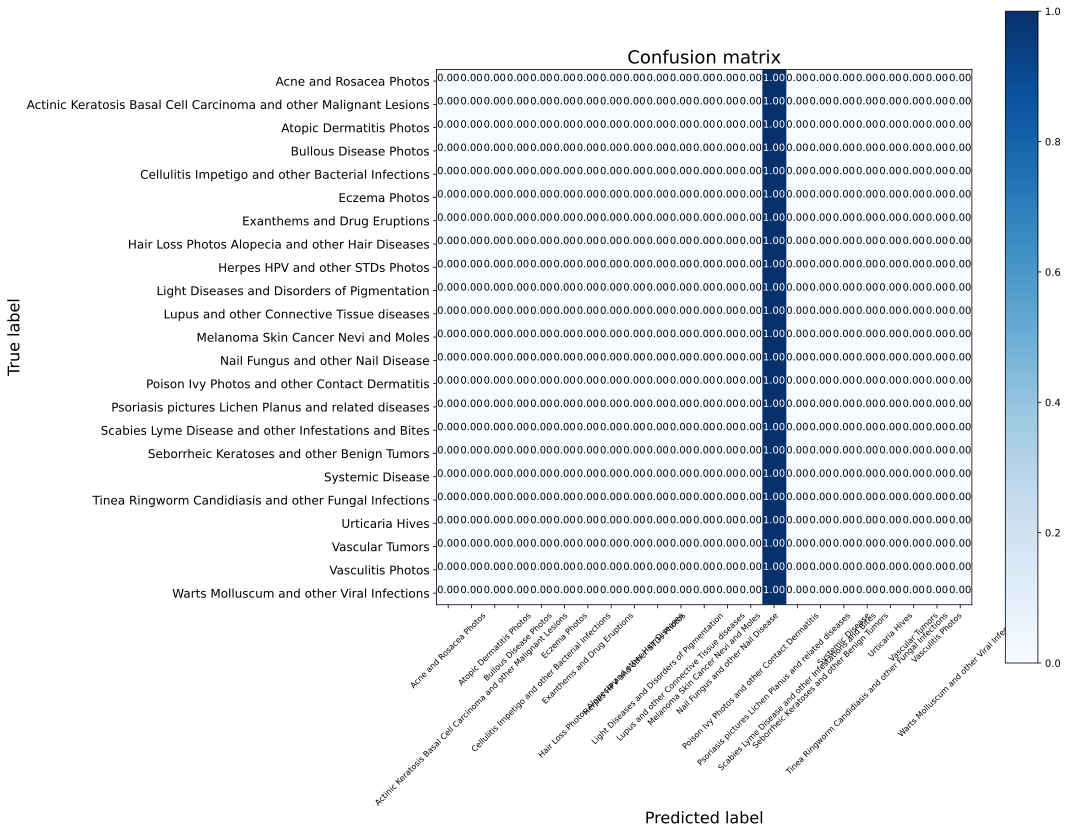

In [55]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [56]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.00      0.00      0.00       168
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00       229
                                          Atopic Dermatitis Photos       0.00      0.00      0.00        97
                                            Bullous Disease Photos       0.00      0.00      0.00        89
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        57
                                                     Eczema Photos       0.00      0.00      0.00       247
                                      Exanthems and Drug Eruptions       0.00      0.00      0.00        80
                 Hair Loss Photos Alopecia and other Hair Diseases       0.00      0.00      0.00        47
                           

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confugn matrix по валидационным данным

In [57]:
%%time
Y_pred1 = model.predict_generator(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

667/667 [==============================] - 46s 69ms/step
CPU times: user 1min 4s, sys: 3.83 s, total: 1min 8s
Wall time: 45.9 s


array([14, 14, 14, ..., 14, 14, 14])

In [58]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


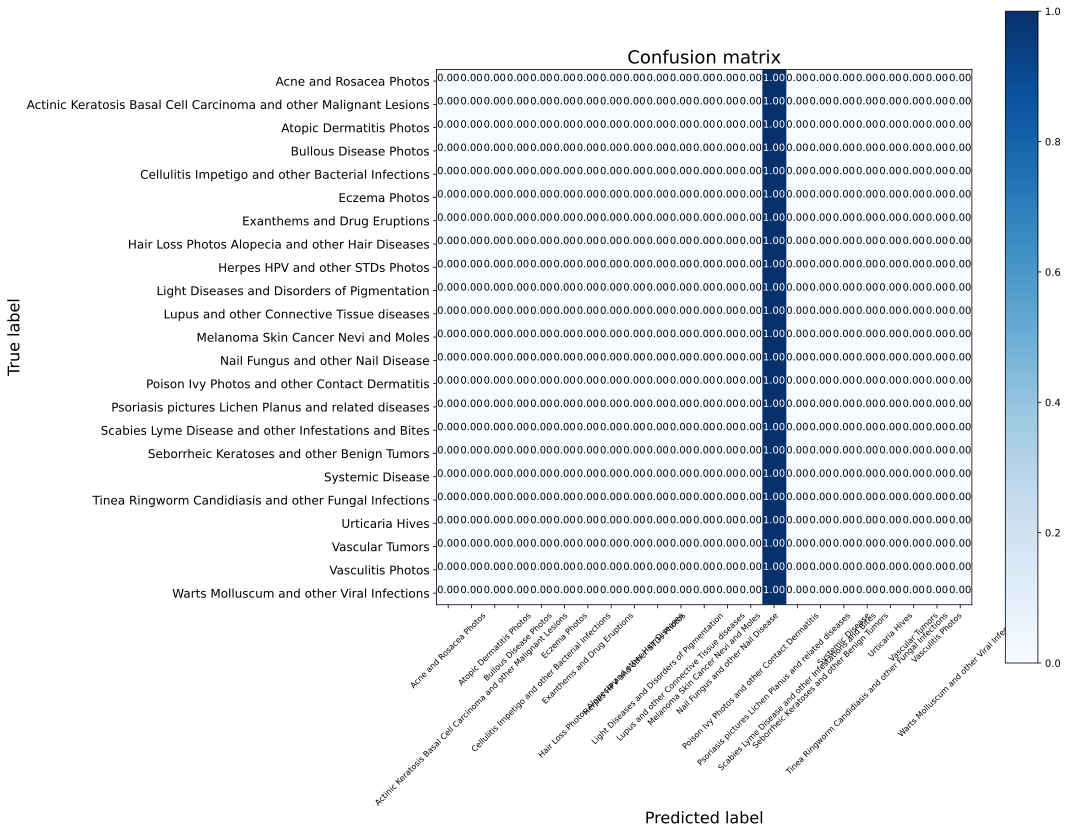

In [59]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [60]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.00      0.00      0.00       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00       288
                                          Atopic Dermatitis Photos       0.00      0.00      0.00       123
                                            Bullous Disease Photos       0.00      0.00      0.00       113
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        73
                                                     Eczema Photos       0.00      0.00      0.00       309
                                      Exanthems and Drug Eruptions       0.00      0.00      0.00       101
                 Hair Loss Photos Alopecia and other Hair Diseases       0.00      0.00      0.00        60
                           

# Tестовая демонстрация.

In [91]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    tta_step = 3
    predictions = []
    for i in range(tta_step):
        preds = model.predict(np.asarray([img]))[0]
        predictions.append(preds)
    pred = np.mean(predictions, axis=0)
    probabilities = pred
#    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [92]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


In [93]:
img2=load_image(train_path + 'Vascular Tumors/angiokeratomas-18.jpg')

In [94]:
img3=np.asarray([img2])
img3

array([[[[0.32156863, 0.36862745, 0.4627451 ],
         [0.35686275, 0.40392157, 0.49803922],
         [0.35294118, 0.4       , 0.49411765],
         ...,
         [0.21960784, 0.28627451, 0.39215686],
         [0.22352941, 0.29019608, 0.39607843],
         [0.21960784, 0.28627451, 0.39215686]],

        [[0.35294118, 0.4       , 0.49411765],
         [0.29803922, 0.34509804, 0.43921569],
         [0.30980392, 0.35686275, 0.45098039],
         ...,
         [0.23921569, 0.30196078, 0.41568627],
         [0.23921569, 0.30196078, 0.41176471],
         [0.24313725, 0.30588235, 0.41960784]],

        [[0.37647059, 0.42745098, 0.51764706],
         [0.37254902, 0.42352941, 0.51372549],
         [0.34509804, 0.39607843, 0.49019608],
         ...,
         [0.23921569, 0.30196078, 0.41960784],
         [0.25882353, 0.31764706, 0.43921569],
         [0.25098039, 0.31372549, 0.43137255]],

        ...,

        [[0.04313725, 0.02745098, 0.04705882],
         [0.04313725, 0.02745098, 0.04705882]

In [95]:
pr = model.predict(img3)[0]

In [98]:
pr

array([0.04580524, 0.08506227, 0.03654201, 0.02983405, 0.01967536,
       0.07198562, 0.03249452, 0.01820941, 0.02664362, 0.04367291,
       0.02714258, 0.02876377, 0.05812186, 0.01619938, 0.098658  ,
       0.0276252 , 0.07741903, 0.04293631, 0.07487801, 0.0152161 ,
       0.02661596, 0.02598716, 0.07051167], dtype=float32)

In [96]:
class_idx1 = np.argmax(pr)
class_idx1

14

In [99]:
class_idx2 = (-pr).argsort()[:3] 
class_idx2

array([14,  1, 16])

In [ ]:
prediction

Источник: class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, file: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-keratosis-lesion-27.jpg
Предсказано: класс: Psoriasis pictures Lichen Planus and related diseases, с вероятностью: 0.098657
Предсказано: класс: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, с вероятностью: 0.085062
Предсказано: класс: Seborrheic Keratoses and other Benign Tumors, с вероятностью: 0.077419


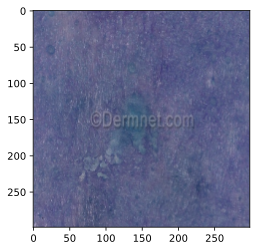

<Figure size 432x288 with 0 Axes>

Источник: class: Seborrheic Keratoses and other Benign Tumors, file: Seborrheic Keratoses and other Benign Tumors/epidermal-cyst-118.jpg
Предсказано: класс: Psoriasis pictures Lichen Planus and related diseases, с вероятностью: 0.098657
Предсказано: класс: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, с вероятностью: 0.085061
Предсказано: класс: Seborrheic Keratoses and other Benign Tumors, с вероятностью: 0.077419


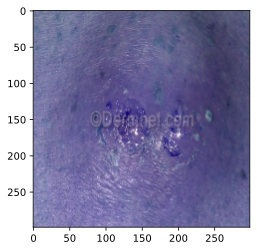

Источник: class: Vascular Tumors, file: Vascular Tumors/hemangioma-3.jpg
Предсказано: класс: Psoriasis pictures Lichen Planus and related diseases, с вероятностью: 0.098658
Предсказано: класс: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions, с вероятностью: 0.085062
Предсказано: класс: Seborrheic Keratoses and other Benign Tumors, с вероятностью: 0.077419


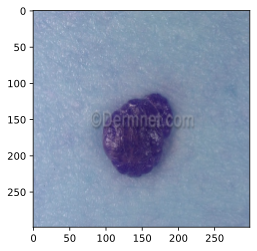

<Figure size 432x288 with 0 Axes>

In [100]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# TTA

In [72]:
tta_step = 10 
predictions = []

In [74]:
tta_step = 5 
predictions = []
for i in range(tta_step):
    preds = model.predict_generator(test_generator, verbose = 1)
    predictions.append(preds)
pred = np.mean(predictions, axis=0)

518/518 [==============================] - 36s 69ms/step


In [77]:
predictions

[array([[0.04580537, 0.08506004, 0.03654167, ..., 0.02661672, 0.02598774,
         0.07051129],
        [0.04580505, 0.0850597 , 0.03654159, ..., 0.02661664, 0.02598783,
         0.07051207],
        [0.04580606, 0.08506086, 0.03654189, ..., 0.02661687, 0.02598752,
         0.07050998],
        ...,
        [0.04580561, 0.08506023, 0.03654137, ..., 0.02661674, 0.02598763,
         0.07051104],
        [0.04580554, 0.08505987, 0.03654348, ..., 0.02661703, 0.02598816,
         0.07050985],
        [0.04580535, 0.08505899, 0.03654194, ..., 0.02661706, 0.0259881 ,
         0.07051121]], dtype=float32),
 array([[0.04580567, 0.0850581 , 0.03654416, ..., 0.02661768, 0.02598881,
         0.07050911],
        [0.04580675, 0.08505967, 0.0365417 , ..., 0.02661754, 0.02598785,
         0.07050833],
        [0.04580518, 0.08506257, 0.03654216, ..., 0.02661588, 0.02598709,
         0.07051159],
        ...,
        [0.04580507, 0.08505979, 0.03654158, ..., 0.02661664, 0.0259878 ,
         0.07051204

In [78]:
pred = np.mean(predictions, axis=0)

In [79]:
pred

array([[0.04580553, 0.08505966, 0.03654214, ..., 0.02661697, 0.02598795,
        0.07051064],
       [0.04580569, 0.0850599 , 0.03654186, ..., 0.02661695, 0.02598782,
        0.07051055],
       [0.04580558, 0.08506044, 0.03654201, ..., 0.02661673, 0.02598769,
        0.07051074],
       ...,
       [0.04580543, 0.08506079, 0.03654169, ..., 0.02661652, 0.02598752,
        0.07051125],
       [0.04580551, 0.08505966, 0.03654242, ..., 0.02661698, 0.025988  ,
        0.07051061],
       [0.04580537, 0.08506123, 0.0365419 , ..., 0.02661636, 0.02598745,
        0.07051122]], dtype=float32)

In [80]:
#predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())


In [81]:
label_map

{0: 'Acne and Rosacea Photos',
 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 2: 'Atopic Dermatitis Photos',
 3: 'Bullous Disease Photos',
 4: 'Cellulitis Impetigo and other Bacterial Infections',
 5: 'Eczema Photos',
 6: 'Exanthems and Drug Eruptions',
 7: 'Hair Loss Photos Alopecia and other Hair Diseases',
 8: 'Herpes HPV and other STDs Photos',
 9: 'Light Diseases and Disorders of Pigmentation',
 10: 'Lupus and other Connective Tissue diseases',
 11: 'Melanoma Skin Cancer Nevi and Moles',
 12: 'Nail Fungus and other Nail Disease',
 13: 'Poison Ivy Photos and other Contact Dermatitis',
 14: 'Psoriasis pictures Lichen Planus and related diseases',
 15: 'Scabies Lyme Disease and other Infestations and Bites',
 16: 'Seborrheic Keratoses and other Benign Tumors',
 17: 'Systemic Disease',
 18: 'Tinea Ringworm Candidiasis and other Fungal Infections',
 19: 'Urticaria Hives',
 20: 'Vascular Tumors',
 21: 'Vasculitis Photos',
 22: 'Warts Molluscum and other Viral

In [83]:
predictions

[array([[0.04580537, 0.08506004, 0.03654167, ..., 0.02661672, 0.02598774,
         0.07051129],
        [0.04580505, 0.0850597 , 0.03654159, ..., 0.02661664, 0.02598783,
         0.07051207],
        [0.04580606, 0.08506086, 0.03654189, ..., 0.02661687, 0.02598752,
         0.07050998],
        ...,
        [0.04580561, 0.08506023, 0.03654137, ..., 0.02661674, 0.02598763,
         0.07051104],
        [0.04580554, 0.08505987, 0.03654348, ..., 0.02661703, 0.02598816,
         0.07050985],
        [0.04580535, 0.08505899, 0.03654194, ..., 0.02661706, 0.0259881 ,
         0.07051121]], dtype=float32),
 array([[0.04580567, 0.0850581 , 0.03654416, ..., 0.02661768, 0.02598881,
         0.07050911],
        [0.04580675, 0.08505967, 0.0365417 , ..., 0.02661754, 0.02598785,
         0.07050833],
        [0.04580518, 0.08506257, 0.03654216, ..., 0.02661588, 0.02598709,
         0.07051159],
        ...,
        [0.04580507, 0.08505979, 0.03654158, ..., 0.02661664, 0.0259878 ,
         0.07051204

In [84]:
predictions = [label_map[k] for k in pred]
predictions

TypeError: unhashable type: 'numpy.ndarray'

In [85]:
pred[0]

array([0.04580553, 0.08505966, 0.03654214, 0.02983462, 0.01967639,
       0.07198451, 0.03249531, 0.01821035, 0.02664418, 0.0436734 ,
       0.02714352, 0.02876457, 0.05812187, 0.0162003 , 0.09865414,
       0.02762616, 0.07741692, 0.04293653, 0.07487729, 0.01521705,
       0.02661697, 0.02598795, 0.07051064], dtype=float32)

In [90]:
predictions[0][2][0]

0.045806058

# Сохранение модели для продакшн

In [ ]:
channel.queue_declare(queue='Features')

In [ ]:
def callback(ch, method, properties, body):
    print(f'Получен вектор признаков {body}')

In [ ]:
# on_message_callback показывает какую функцию вызвать при получении сообщения
channel.basic_consume(
    queue='Features', on_message_callback=callback, auto_ack=True)
print('...Ожидание сообщений, для выхода нажмите CTRL+C')

In [ ]:
channel.start_consuming()

In [ ]:
import pika
      ___(1)___
connection = ___(2)___(
    pika.ConnectionParameters(host='localhost'))
      ___(3)___ = connection.channel()

channel.queue_declare(queue='y_true')
channel.queue_declare(___(4)___)

def ___(5)___(ch, method, ___(6)___, body):
    print(f'Из очереди {method.routing_key} получено значение {json.loads(___(7)___)}')

channel.basic_consume(
    queue='y_predict', on_message_callback=callback, auto_ack=True)

channel.basic_consume(
      queue=___(8)___, on_message_callback=callback, auto_ack=True)

print('...Ожидание сообщений, для выхода нажмите CTRL+C')
      channel.___(9)___()

In [ ]:
plot_any([test_binary, new_img, final_result])